In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from bartpy.bartpy.sklearnmodel import SklearnModel
from tqdm import tqdm

from scipy.special import logit, expit
from scipy.stats import bernoulli

import simulate_data.simulate_data as sd


In [3]:
n=250
N_replications=35
# data

data = sd.make_zaidi_data_A(n)

Y,W,X,tau,pi = sd.get_data(data,n,1)

Y_i_star = sd.get_Y_i_star(Y,W,pi)


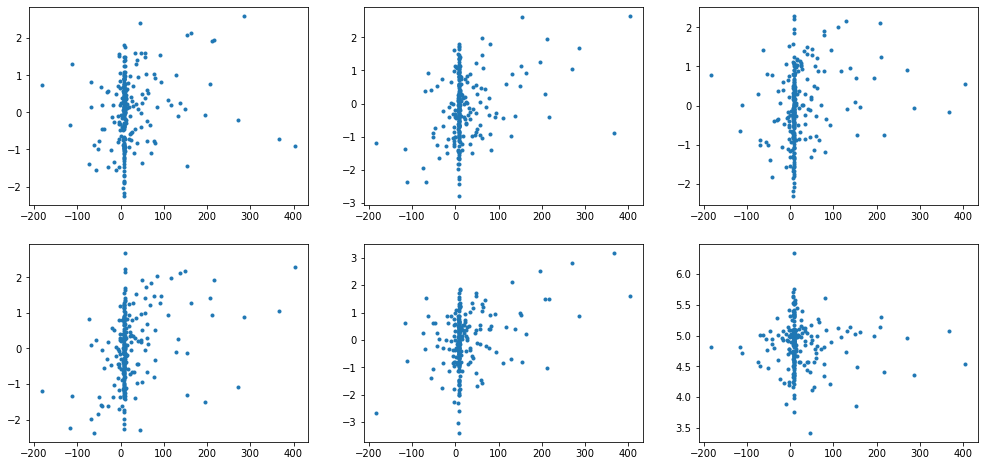

In [4]:
plt.figure(figsize=(17,8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(Y, X[:,i], '.')

In [5]:
post_samples = sd.get_posterior_samples_data(
    stem="experiment_results/A/known/all_runs_with_ps",
    nreps=N_replications,
    nsamp=2000,
    nburn=2000,
    ntree=35,
    nchain=4,
    thin=.1,
    alpha=0.95,
    beta=2.,
    k=2.0,
)
print(post_samples.shape)

(800, 250, 35)


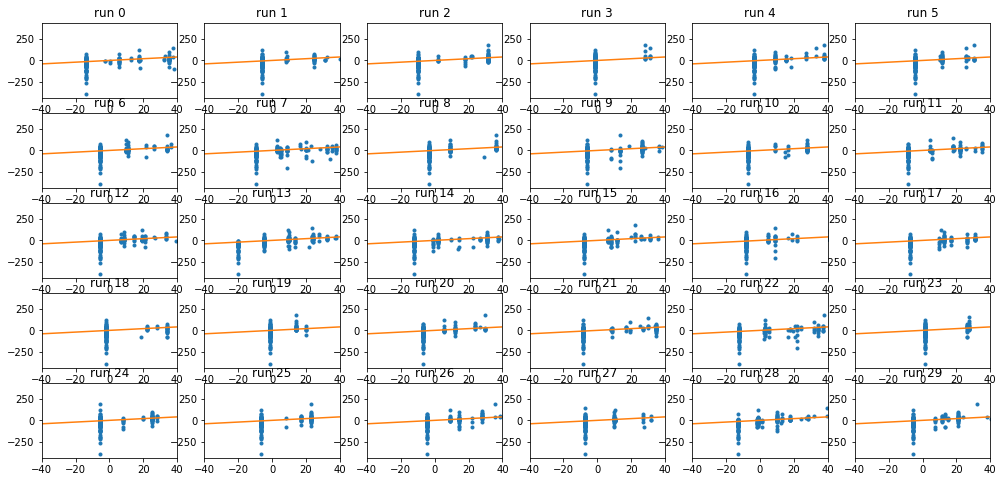

In [6]:
plt.figure(figsize=(17,8))
for i in range(30):
    base = list(range(np.min(tau).astype(int),np.max(tau).astype(int)))
    samp_df=pd.DataFrame(post_samples[:,:,i])
    CATE=np.mean(post_samples[:,:,i], axis=0)
    plt.subplot(5, 6, i+1)
    plt.plot(CATE, tau, '.')
    plt.plot(base, base)
    plt.xlim((-40,40))
    plt.title("run " + str(i))

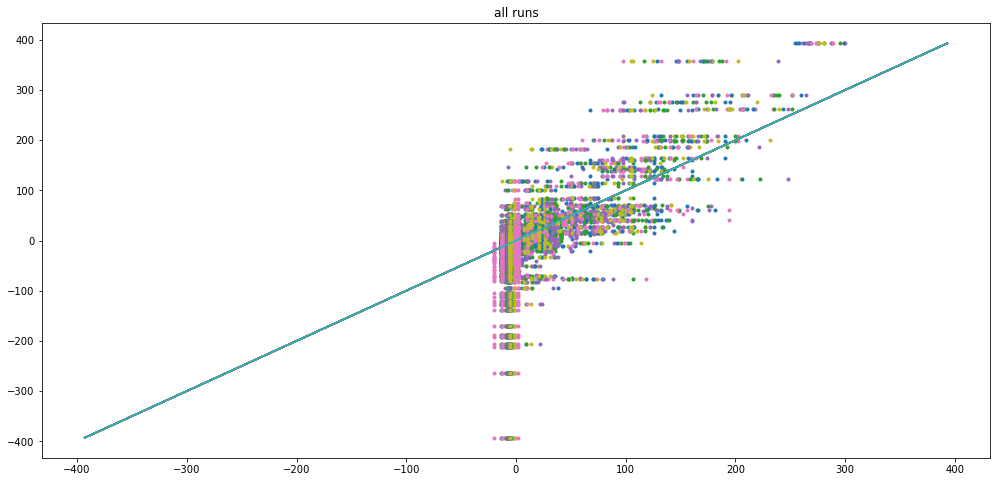

In [7]:
plt.figure(figsize=(17,8))
for i in range(30):
    base = list(range(np.min(tau).astype(int),np.max(tau).astype(int)))
    samp_df=pd.DataFrame(post_samples[:,:,i])
    CATE=np.mean(post_samples[:,:,i], axis=0)
    #plt.subplot(5, 6, i+1)
    plt.plot(CATE, tau, '.')
    plt.plot(base, base)
    #plt.xlim((-40,40))
    plt.title("all runs")

MSE: 3550.166526070454
Bias: -12.199702802622687


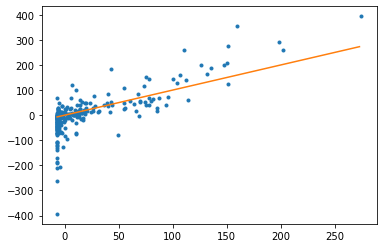

In [8]:
mean_pred_CATE = np.mean(np.mean(post_samples, axis=0), axis=1)
base = list(
    range(
        np.min(mean_pred_CATE).astype(int),
        np.max(mean_pred_CATE).astype(int)
    )
)
plt.plot(mean_pred_CATE, tau, '.')
plt.plot(base, base)
#plt.xlim((-40,40))
#plt.ylim((-40,40))

print("MSE:", np.mean((mean_pred_CATE-tau)**2)) # trying to beat 4191.665
print("Bias:", np.mean(tau-mean_pred_CATE))


In [9]:
tau_matrix = np.zeros((n,N_replications))
for i in range(N_replications):
    tau_matrix[:,i]=tau

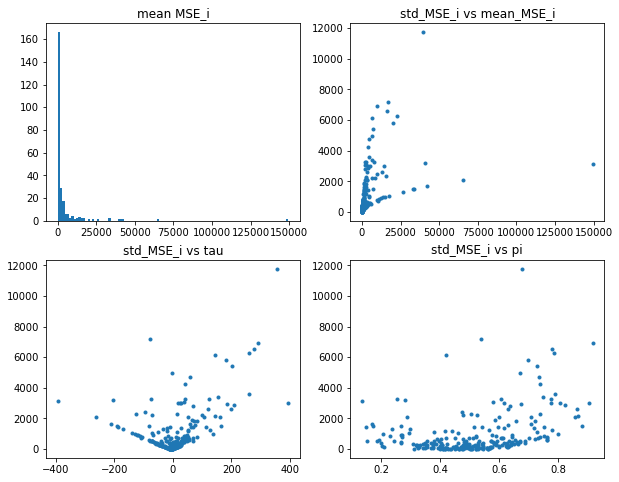

In [14]:
# MSE
pred_CATE = np.mean(post_samples, axis=0)

mean_MSE_i = np.mean((pred_CATE-tau_matrix)**2, axis=1)
mean_MSE_i = np.mean((pred_CATE-tau_matrix)**2, axis=1)

std_MSE_i = np.std((pred_CATE-tau_matrix)**2, axis=1)
std_MSE_i = np.std((pred_CATE-tau_matrix)**2, axis=1)

plt.figure(figsize=(10,8))
plt.subplot(2, 2, 1)
_=plt.hist(mean_MSE_i, 100)
#_=plt.xlim((0,200))
_=plt.title("mean MSE_i")



plt.subplot(2, 2, 2)
_=plt.plot(mean_MSE_i, std_MSE_i, '.')
#_=plt.ylim((0,5000))
#_=plt.xlim((0,20000))
_=plt.title("std_MSE_i vs mean_MSE_i")


plt.subplot(2, 2, 3)
_=plt.plot(tau, std_MSE_i, '.')
#_=plt.ylim((0,5000))
_=plt.title("std_MSE_i vs tau")


plt.subplot(2, 2, 4)
_=plt.plot(pi, std_MSE_i, '.')
#_=plt.ylim((0,5000))
_=plt.title("std_MSE_i vs pi")


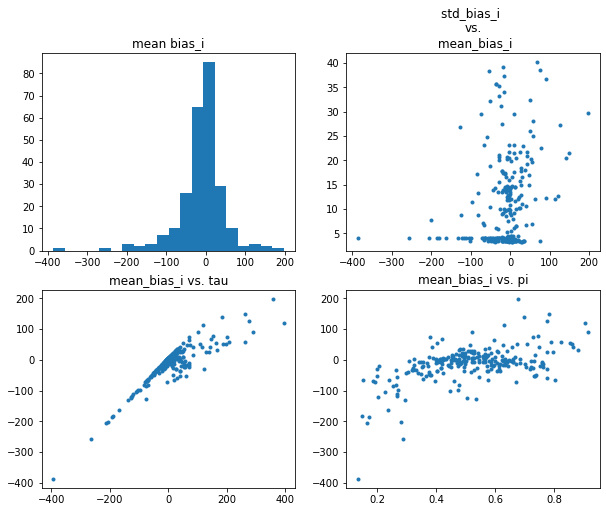

In [16]:
# Bias
    
mean_bias_i = np.mean(tau_matrix-pred_CATE, axis=1)

std_bias_i = np.std(tau_matrix-pred_CATE, axis=1)

plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
_=plt.hist(mean_bias_i, 20)
#_=plt.xlim((-100,100))
_=plt.title("mean bias_i")

plt.subplot(2, 2, 2)
_=plt.plot(mean_bias_i, std_bias_i, '.')
#_=plt.xlim((-20,20))
#_=plt.ylim((0,20))
_=plt.title("std_bias_i \nvs.\n mean_bias_i")

plt.subplot(2, 2, 3)
_=plt.plot(tau, mean_bias_i,'.')
#plt.ylim((-100,100))
_=plt.title("mean_bias_i vs. tau")

plt.subplot(2, 2, 4)
_=plt.plot(pi, mean_bias_i,'.')
_=plt.title("mean_bias_i vs. pi")
#plt.ylim((-100,100))
plt.show()

In [17]:
#Coverage

for i in tqdm(range(N_replications)):
    if (i==0):
        coverage_matrix=post_samples[:,:,i]
    else:
        coverage_matrix=np.concatenate([coverage_matrix, post_samples[:,:,i]], axis=0)

100%|██████████| 35/35 [00:00<00:00, 55.38it/s] 


In [18]:
q975 = np.quantile( coverage_matrix, q=0.975, axis=0)
q025 = np.quantile( coverage_matrix, q=0.025, axis=0)
U=np.array(tau<q975).astype(int)
L= np.array(q025<tau).astype(int)

print("Covereage score:", sum(U*L)/n)


Covereage score: 0.636


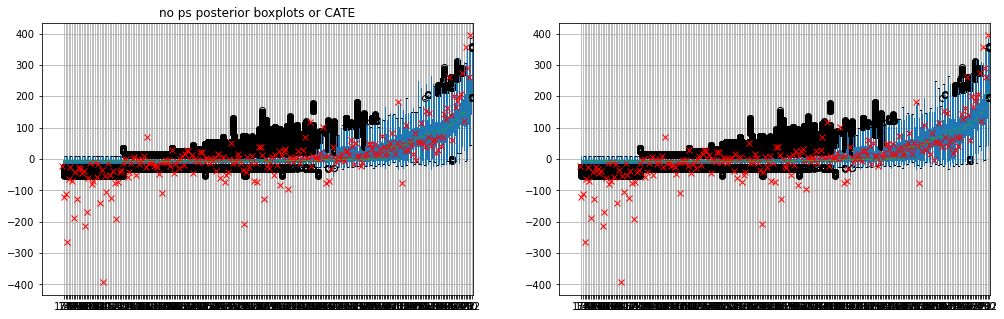

In [19]:
# No Propesnity Scores
coverage_matrix=pd.DataFrame(coverage_matrix)
index_values=coverage_matrix.mean(axis=0).sort_values().index
temp2 = coverage_matrix.reindex(index_values, axis=1)
plt.figure(figsize=(17,5))
plt.subplot(1, 2, 1)
_=temp2.boxplot()
_=plt.plot(tau[index_values],'x', color='red')
plt.title("no ps posterior boxplots or CATE")
plt.subplot(1, 2, 2)
_=temp2.boxplot()
_=plt.plot(tau[index_values],'x', color='red')
#_=plt.ylim((-25,25))
plt.show()


Key Observation:  Coverage appears to be good on average except at extrems of estimated CATE.  Reasons for this?

In [20]:
coverage_indicator = np.zeros((N_replications, n))
for i in tqdm(range(N_replications)):

        #post_samples = post_samples[:,:,i]#model[i].get_posterior_CATE()
        q975 = np.quantile( post_samples[:,:,i], q=0.975, axis=0)
        q025 = np.quantile( post_samples[:,:,i], q=0.025, axis=0)
        U=np.array(tau<q975).astype(int)
        L= np.array(q025<tau).astype(int)
        I_coverage = np.floor((U+L)/2)
        coverage_indicator[i,:] = I_coverage


100%|██████████| 35/35 [00:00<00:00, 132.92it/s]


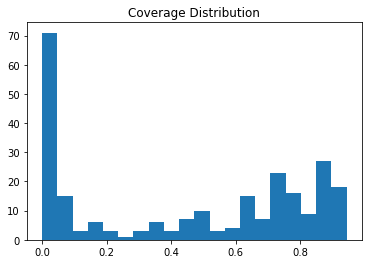

In [21]:

coverage_ratio = (
    np.sum(coverage_indicator, axis=0)/
    coverage_indicator.shape[0]
)

_=plt.hist(coverage_ratio, 20)
_=plt.title("Coverage Distribution")

In [22]:
# ATE Bias
print("Bias in ATE:", np.mean(tau) - np.mean(pred_CATE) )


Bias in ATE: -12.199702802622681


In [17]:
#   Model Type Mean                         Mean Square Error   Mean Bias  95% CI Coverage
# 1 Gaussian-Process Mixture                         4191.665      13.207            0.780
# 2 Bayesian Additive Regression Tree                5856.135      -5.351            0.596
# 3 Transformed Outcome Tree                         7769.077      14.374            0.876
# 4 Fit Based Tree                                   6154.396      15.633            0.928
# 5 Causal Tree                                      8390.039      21.923            0.964
# 6 Transformed Outcome Random Forest                4993.576       0.317            0.932

# 7 BART Mixture 35 trees, (k=2)                     3550.167     -12.200            0.636
